### In this notebook the effects of filtering on the cross correlation are analysed

#### Importing libraries

In [36]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy import signal
from scipy.fft import fft, ifft, ifftshift, rfft

#### Defining paths

In [37]:
data_path =  r"..\data\avstand_1.npz"
noise_path = r"..\data\avstand_1_noise.npz"

#### Loading data 

In [38]:
data_noise = np.load(noise_path)['data']
data = np.load(data_path)['data']

#### Generating Random Noise Data

Assuming that the background noise of the system can be approximated as white gaussian background noise. 



In [39]:
mean = 0
std = 1
num_samples = 1000
w1 = np.random.normal(mean, std, size=num_samples)
w2 = np.random.normal(mean, std, size=num_samples)

#### Defining the two system noise variables we will analyse in this notebook

In [40]:
q1 = data_noise[0][:num_samples]
q2 = data_noise[1][:num_samples]

#### Defining Cross Correlation Parameters

In [41]:
numtaps = 1001
truncate_length = 60
window_type = signal.windows.boxcar
beta = 1
correlation_type = np.real
band_width = 1000
frequencies = np.linspace(1000, 40000, 100)
sampling_rate = 204800 #Hz

#### Defining Cross Correlation Functions

In [42]:
filters = []
# creating filters bandpass
for frequency in frequencies:
    h = signal.firwin(numtaps, [frequency - band_width//2, frequency + band_width//2], fs=sampling_rate, pass_zero="bandpass")
    filters.append(h)

def truncate_time_shift(time_shift,length):
    index_0 = len(time_shift)/2
    start_index = int(index_0 - length/2)
    end_index = int(index_0 + length/2)
    time_shift = time_shift[start_index:end_index]
    return time_shift

def GCC(sensor1, sensor2): 
    GCC_12 = []
    i = 0 
    for h in filters:
        s1 = signal.lfilter(h, 1.0, sensor1)
        s2 = signal.lfilter(h, 1.0, sensor2)

        window = window_type(len(s1))
        s1 = s1 * window
        s2 = s2 * window

        f_s1 = fft(s1)
        f_s2 = fft(s2)

        G12 = f_s1 * np.conj(f_s2)
        denom = abs(G12)
        denom[denom < 1e-6] = 1e-6
        f_s = G12 / denom**beta


        # Er f_s 1 
        cc12 = ifft(f_s)
        cc12 = ifftshift(cc12)

        cc12 = correlation_type(cc12)

        index_0 = len(cc12)/2
        start_index = int(index_0 - truncate_length/2)
        end_index = int(index_0 + truncate_length/2)
        cc12 = cc12[start_index:end_index]

        cc12 = cc12 / np.max(np.abs(cc12))
        GCC_12.append(cc12)
    GCC_12 = np.array(GCC_12)
    return GCC_12


#### GCC creation

In [43]:

GCC_q1_q2 = GCC(q1, q2)
GCC_q1_q1 = GCC(q1, q1)
GCC_q2_q2 = GCC(q2, q2)
GCC_q2_q1 = GCC(q2, q1)

GCC_w1_w2 = GCC(w1, w2)
GCC_w1_w1 = GCC(w1, w1)
GCC_w2_w2 = GCC(w2, w2)
GCC_w2_w1 = GCC(w2, w1)

#### Creating the time_shifts 

In [44]:
dt = 1 / sampling_rate
time_shifts = np.arange(-num_samples*dt,num_samples*dt,dt)
time_shifts = truncate_time_shift(time_shifts, truncate_length)

#### Plotting the magnitude and fase information of the system noise and the random noise


In [ ]:
fft_q1 = rfft(q1)
fft_w1 = rfft(w1)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax = ax.ravel()

ax[0].plot(np.log10(np.abs(fft_q1))*20)
ax[0].set_title("Magnitude of frequency spectrum of q1 [dB]")
ax[0].set_xlabel()



#### Cross Correlation of the system noise for different frequency filters

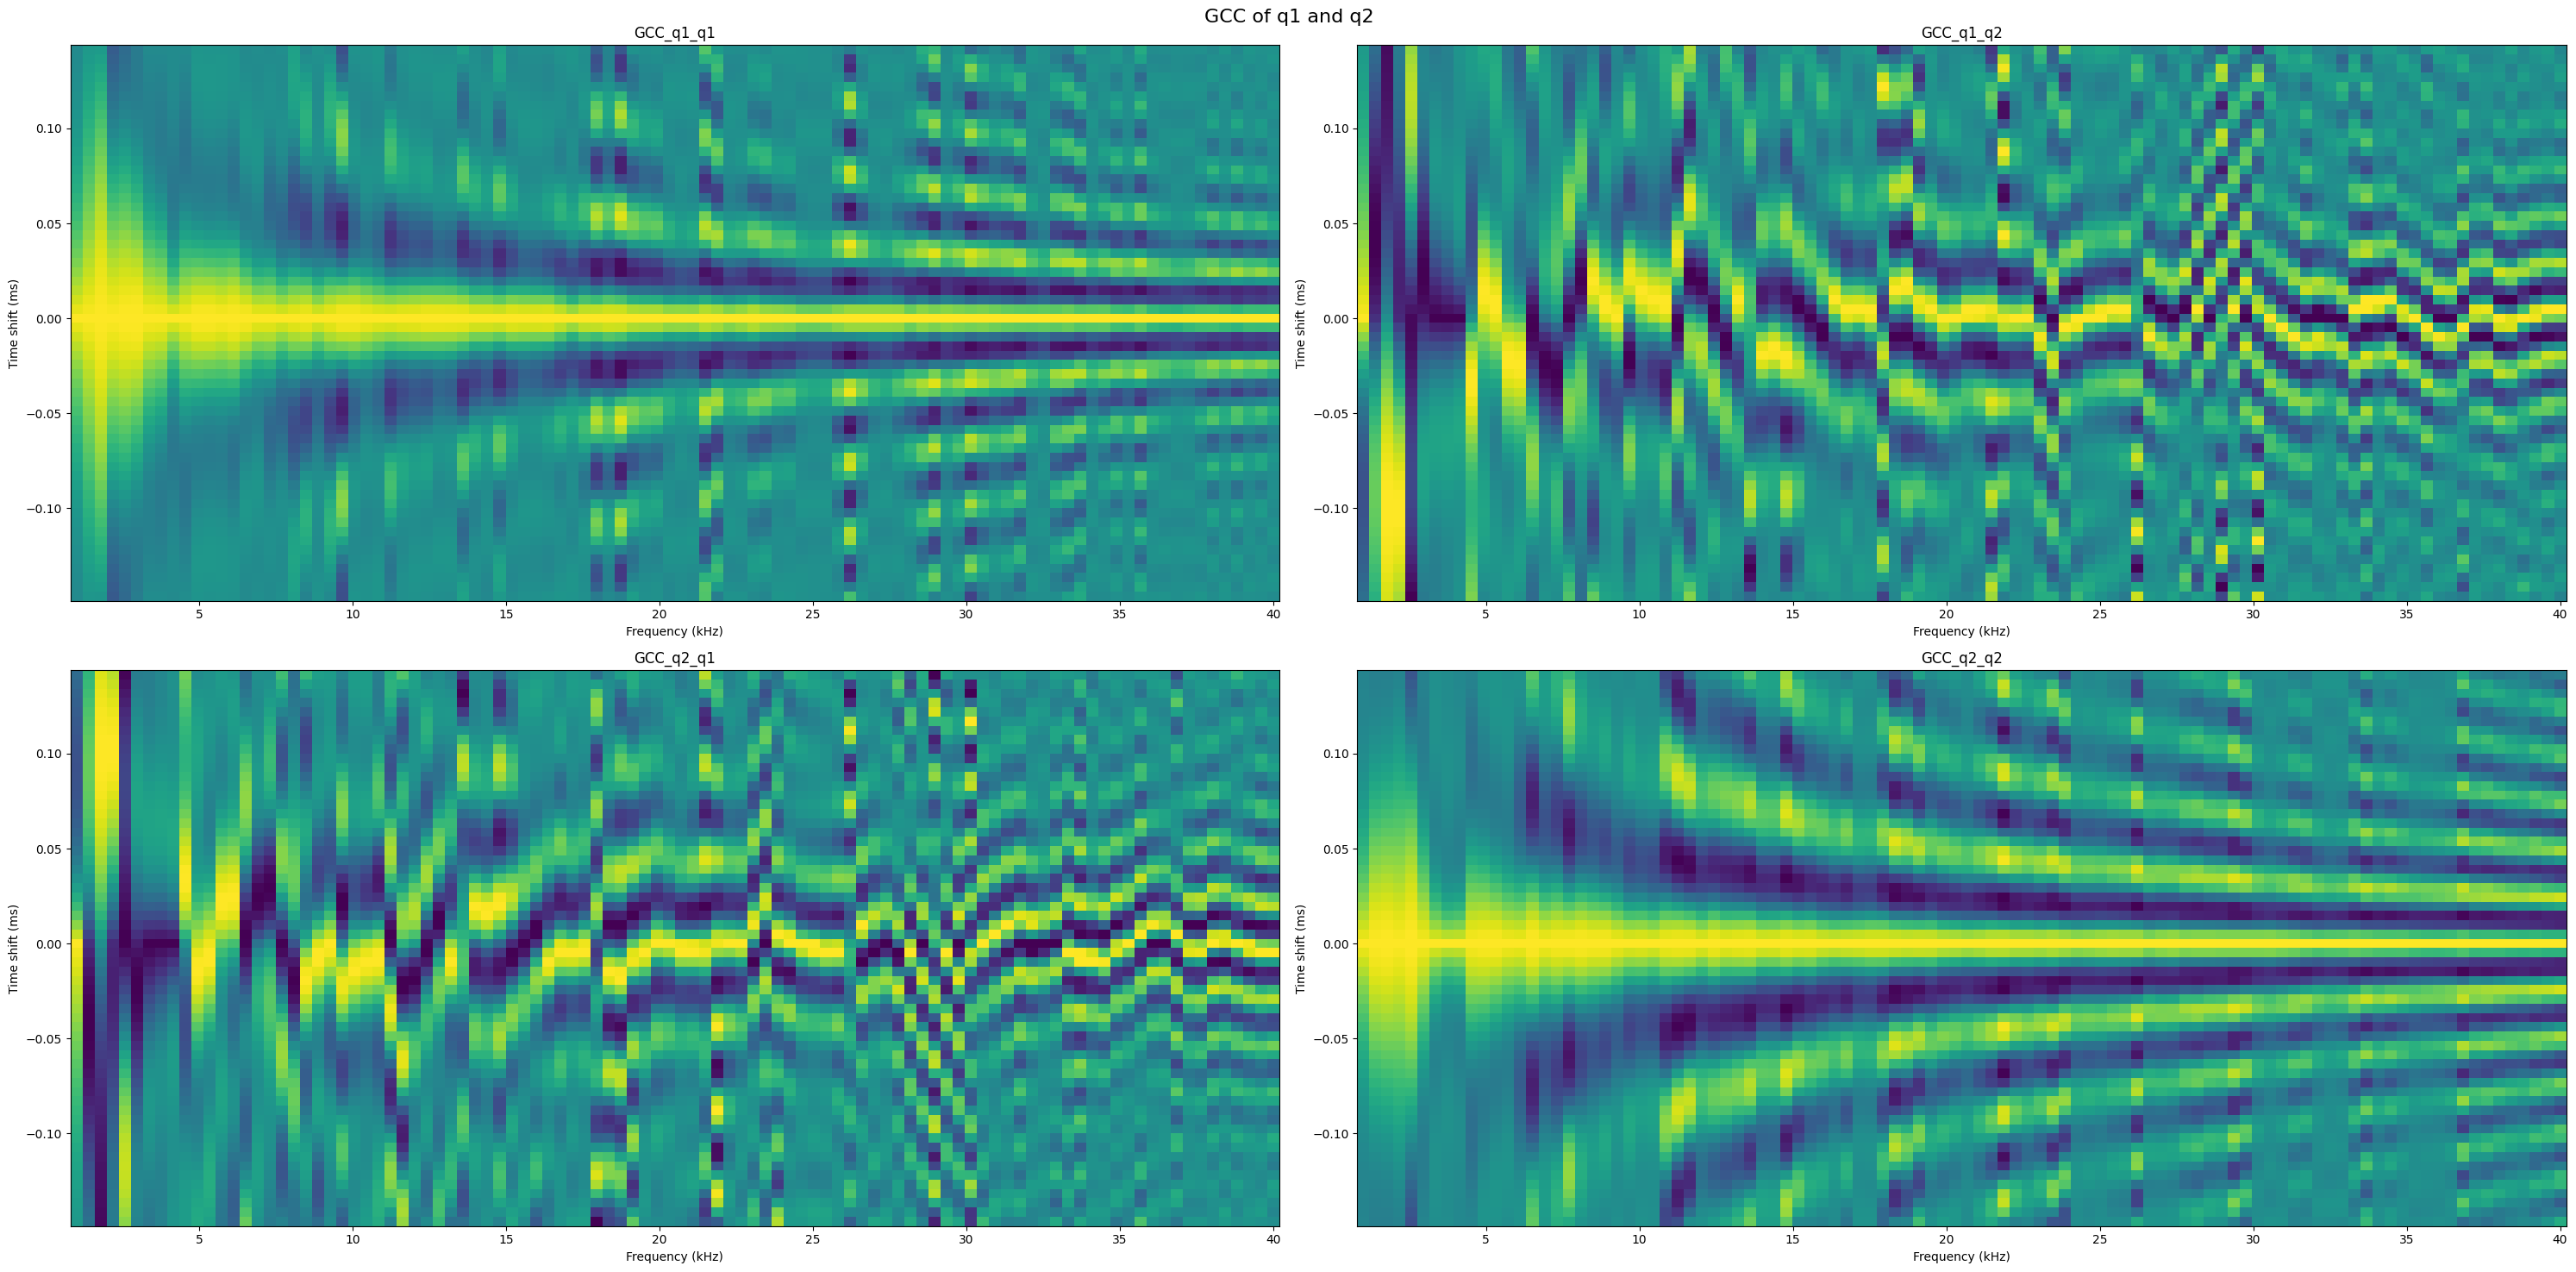

In [45]:

fig, ax = plt.subplots(2,2,figsize=(30,15))
ax = ax.ravel()


ax[1].pcolormesh(frequencies/1000, time_shifts*1000, GCC_q1_q2.T, shading='auto')
ax[1].set_title('GCC_q1_q2')
ax[1].set_xlabel('Frequency (kHz)')
ax[1].set_ylabel('Time shift (ms)')

ax[0].pcolormesh(frequencies/1000, time_shifts*1000, GCC_q1_q1.T, shading='auto')
ax[0].set_title('GCC_q1_q1')
ax[0].set_xlabel('Frequency (kHz)')
ax[0].set_ylabel('Time shift (ms)')

ax[3].pcolormesh(frequencies/1000, time_shifts*1000, GCC_q2_q2.T, shading='auto')
ax[3].set_title('GCC_q2_q2')
ax[3].set_xlabel('Frequency (kHz)')
ax[3].set_ylabel('Time shift (ms)')

ax[2].pcolormesh(frequencies/1000, time_shifts*1000, GCC_q2_q1.T, shading='auto')
ax[2].set_title('GCC_q2_q1')
ax[2].set_xlabel('Frequency (kHz)')
ax[2].set_ylabel('Time shift (ms)')


fig.suptitle('GCC of q1 and q2', fontsize=16)

fig.tight_layout()


#### Cross Correlation of the random noise for different frequency filters

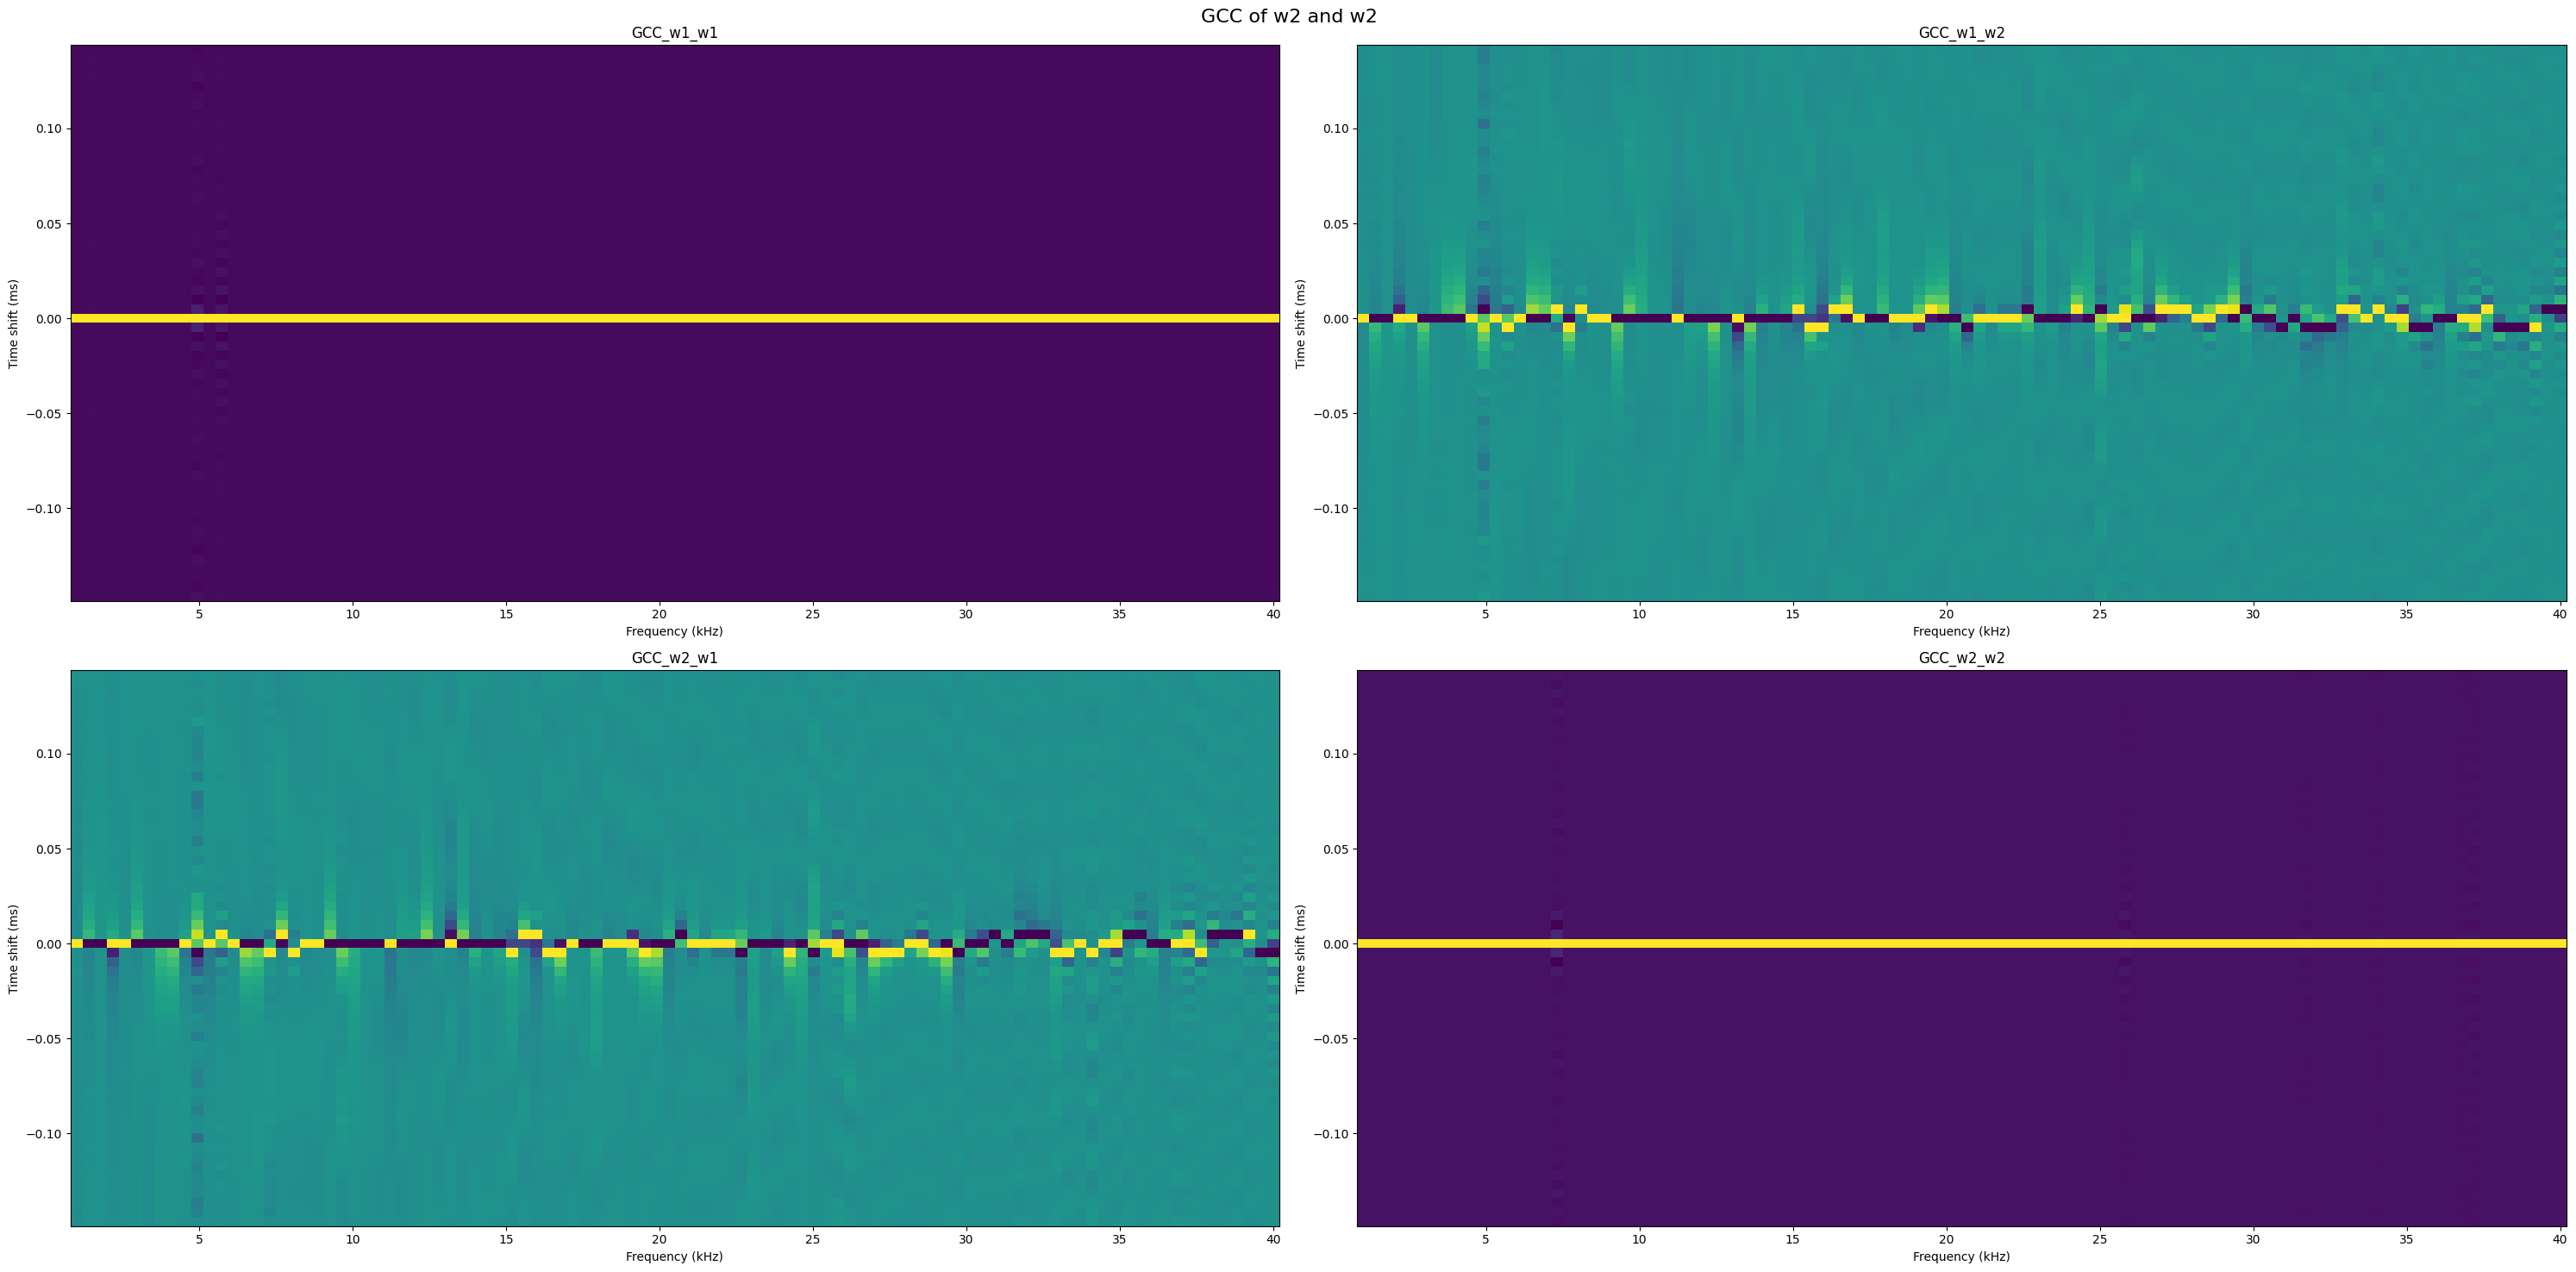

In [46]:

fig, ax = plt.subplots(2,2,figsize=(30,15))
ax = ax.ravel()


ax[0].pcolormesh(frequencies/1000, time_shifts*1000, GCC_w1_w1.T, shading='auto')
ax[0].set_title('GCC_w1_w1')
ax[0].set_xlabel('Frequency (kHz)')
ax[0].set_ylabel('Time shift (ms)')

ax[1].pcolormesh(frequencies/1000, time_shifts*1000, GCC_w1_w2.T, shading='auto')
ax[1].set_title('GCC_w1_w2')
ax[1].set_xlabel('Frequency (kHz)')
ax[1].set_ylabel('Time shift (ms)')

ax[2].pcolormesh(frequencies/1000, time_shifts*1000, GCC_w2_w1.T, shading='auto')
ax[2].set_title('GCC_w2_w1')
ax[2].set_xlabel('Frequency (kHz)')
ax[2].set_ylabel('Time shift (ms)')

ax[3].pcolormesh(frequencies/1000, time_shifts*1000, GCC_w2_w2.T, shading='auto')
ax[3].set_title('GCC_w2_w2')
ax[3].set_xlabel('Frequency (kHz)')
ax[3].set_ylabel('Time shift (ms)')


fig.suptitle('GCC of w2 and w2', fontsize=16)

fig.tight_layout()


#### Calculating the cross correlation and auto correlation for the system noise

100%|██████████| 204/204 [00:00<00:00, 8910.67it/s]


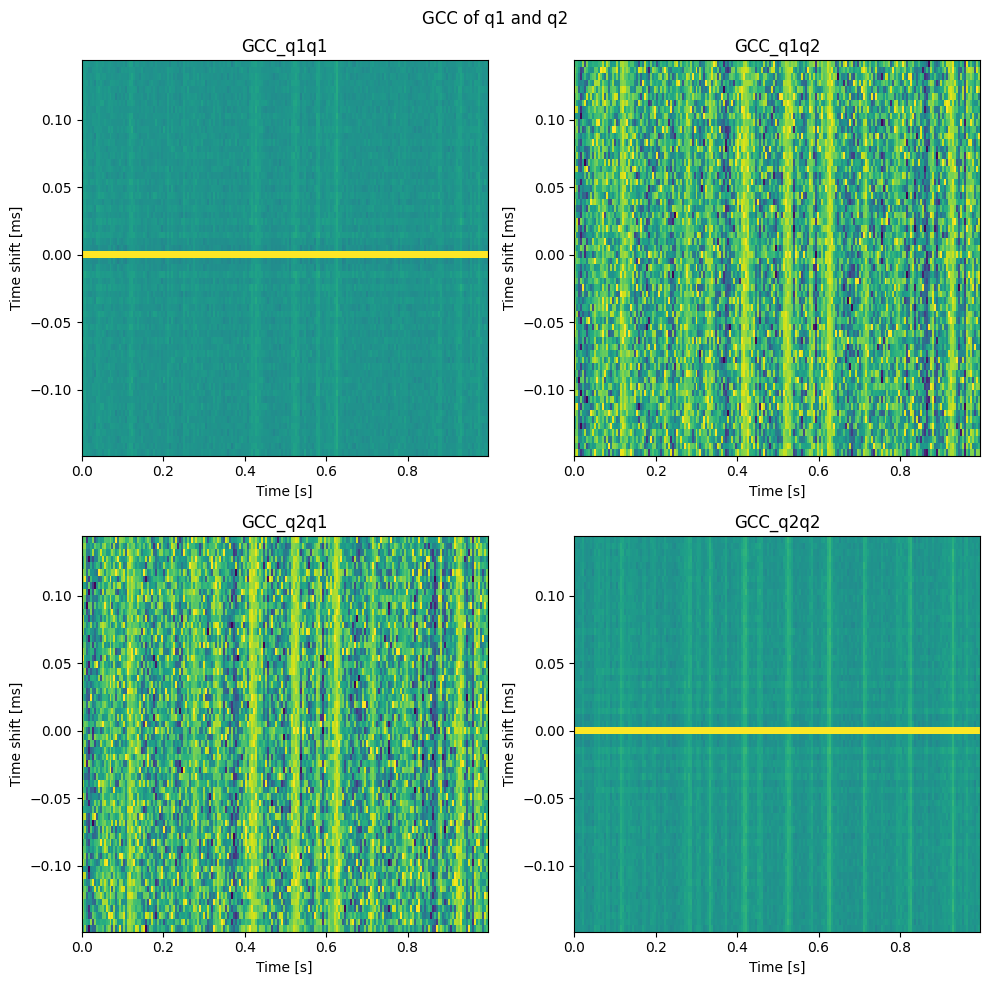

In [163]:
GCC_q1q2 = create_gcc(q1,q2, num_samples, step_size, truncate_length, window_type, beta, correlation_type)
GCC_q1q1 = create_gcc(q1,q1, num_samples, step_size, truncate_length, window_type, beta, correlation_type)
GCC_q2q2 = create_gcc(q2,q2, num_samples, step_size, truncate_length, window_type, beta, correlation_type)
GCC_q2q1 = create_gcc(q2,q1, num_samples, step_size, truncate_length, window_type, beta, correlation_type)

fig, ax = plt.subplots(2,2 ,figsize = (10,10))

ax = ax.ravel()

ax[1].pcolormesh(time, time_shifts*1000, GCC_q1q2.T, vmin = -1, vmax = 1)
ax[1].set_title('GCC_q1q2')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Time shift [ms]')
ax[1].set_aspect('auto')

ax[0].pcolormesh(time, time_shifts*1000, GCC_q1q1.T, vmin = -1, vmax = 1)
ax[0].set_title('GCC_q1q1')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Time shift [ms]')
ax[0].set_aspect('auto')


ax[3].pcolormesh(time, time_shifts*1000, GCC_q2q2.T, vmin = -1, vmax = 1)
ax[3].set_title('GCC_q2q2')
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Time shift [ms]')
ax[3].set_aspect('auto')

ax[2].pcolormesh(time, time_shifts*1000, GCC_q2q1.T, vmin = -1, vmax = 1)
ax[2].set_title('GCC_q2q1')
ax[2].set_xlabel('Time [s]')    
ax[2].set_ylabel('Time shift [ms]')
ax[2].set_aspect('auto')

fig.suptitle('GCC of q1 and q2')
fig.tight_layout()






#### Calculating the cross correlation and auto correlation for the random noise

100%|██████████| 204/204 [00:00<00:00, 9303.45it/s]


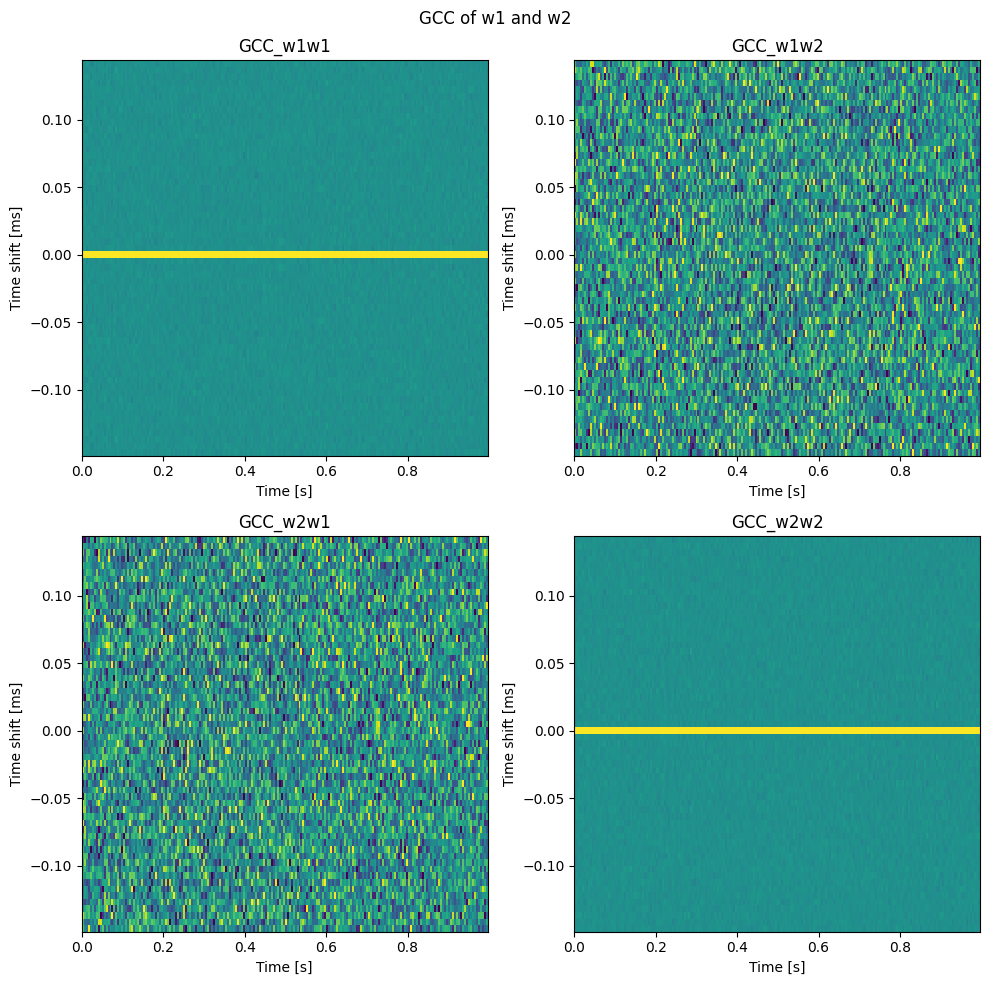

In [164]:
GCC_w1w2 = create_gcc(w1,w2, num_samples, step_size, truncate_length, window_type, beta, correlation_type)
GCC_w1w1 = create_gcc(w1,w1, num_samples, step_size, truncate_length, window_type, beta, correlation_type)
GCC_w2w2 = create_gcc(w2,w2, num_samples, step_size, truncate_length, window_type, beta, correlation_type)
GCC_w2w1 = create_gcc(w2,w1, num_samples, step_size, truncate_length, window_type, beta, correlation_type)

fig, ax = plt.subplots(2,2 ,figsize = (10,10))

ax = ax.ravel()

ax[1].pcolormesh(time, time_shifts*1000, GCC_w1w2.T, vmin = -1, vmax = 1)
ax[1].set_title('GCC_w1w2')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Time shift [ms]')
ax[1].set_aspect('auto')

ax[0].pcolormesh(time, time_shifts*1000, GCC_w1w1.T, vmin = -1, vmax = 1)
ax[0].set_title('GCC_w1w1')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Time shift [ms]')
ax[0].set_aspect('auto')


ax[3].pcolormesh(time, time_shifts*1000, GCC_w2w2.T, vmin = -1, vmax = 1)
ax[3].set_title('GCC_w2w2')
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Time shift [ms]')
ax[3].set_aspect('auto')

ax[2].pcolormesh(time, time_shifts*1000, GCC_w2w1.T, vmin = -1, vmax = 1)
ax[2].set_title('GCC_w2w1')
ax[2].set_xlabel('Time [s]')    
ax[2].set_ylabel('Time shift [ms]')
ax[2].set_aspect('auto')

fig.suptitle('GCC of w1 and w2')
fig.tight_layout()

#### Calculating the cross correlation for the filtered system noise

100%|██████████| 204/204 [00:00<00:00, 9586.87it/s]


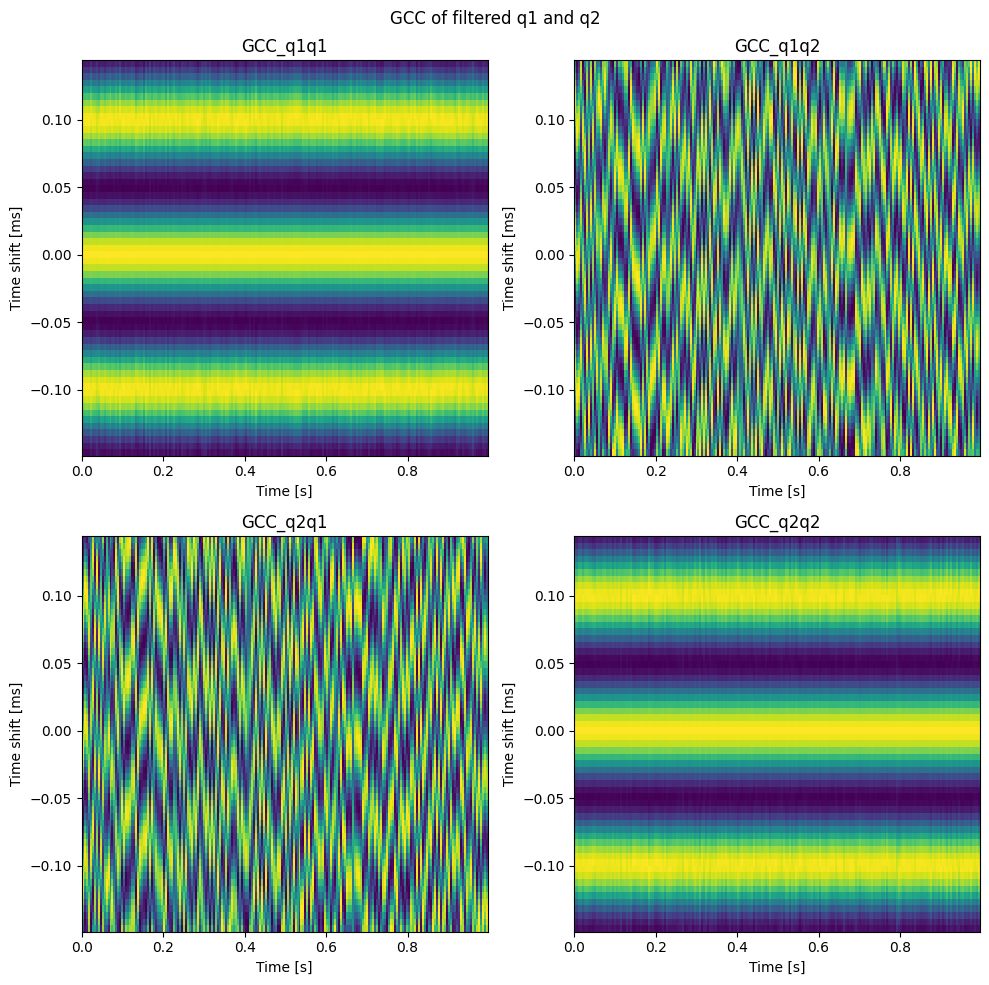

In [165]:
q1 = signal.lfilter(filter, 1.0, q1)
q2 = signal.lfilter(filter, 1.0, q2)


GCC_q1q2 = create_gcc(q1,q2, num_samples, step_size, truncate_length, window_type, beta, correlation_type)
GCC_q1q1 = create_gcc(q1,q1, num_samples, step_size, truncate_length, window_type, beta, correlation_type)
GCC_q2q2 = create_gcc(q2,q2, num_samples, step_size, truncate_length, window_type, beta, correlation_type)
GCC_q2q1 = create_gcc(q2,q1, num_samples, step_size, truncate_length, window_type, beta, correlation_type)


fig, ax = plt.subplots(2,2 ,figsize = (10,10))

ax = ax.ravel()

ax[1].pcolormesh(time, time_shifts*1000, GCC_q1q2.T, vmin = -1, vmax = 1)
ax[1].set_title('GCC_q1q2')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Time shift [ms]')
ax[1].set_aspect('auto')

ax[0].pcolormesh(time, time_shifts*1000, GCC_q1q1.T, vmin = -1, vmax = 1)
ax[0].set_title('GCC_q1q1')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Time shift [ms]')
ax[0].set_aspect('auto')


ax[3].pcolormesh(time, time_shifts*1000, GCC_q2q2.T, vmin = -1, vmax = 1)
ax[3].set_title('GCC_q2q2')
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Time shift [ms]')
ax[3].set_aspect('auto')

ax[2].pcolormesh(time, time_shifts*1000, GCC_q2q1.T, vmin = -1, vmax = 1)
ax[2].set_title('GCC_q2q1')
ax[2].set_xlabel('Time [s]')    
ax[2].set_ylabel('Time shift [ms]')
ax[2].set_aspect('auto')

fig.suptitle('GCC of filtered q1 and q2')
fig.tight_layout()



#### Calculating the cross correlation of the filtered random noise

100%|██████████| 204/204 [00:00<00:00, 11005.84it/s]


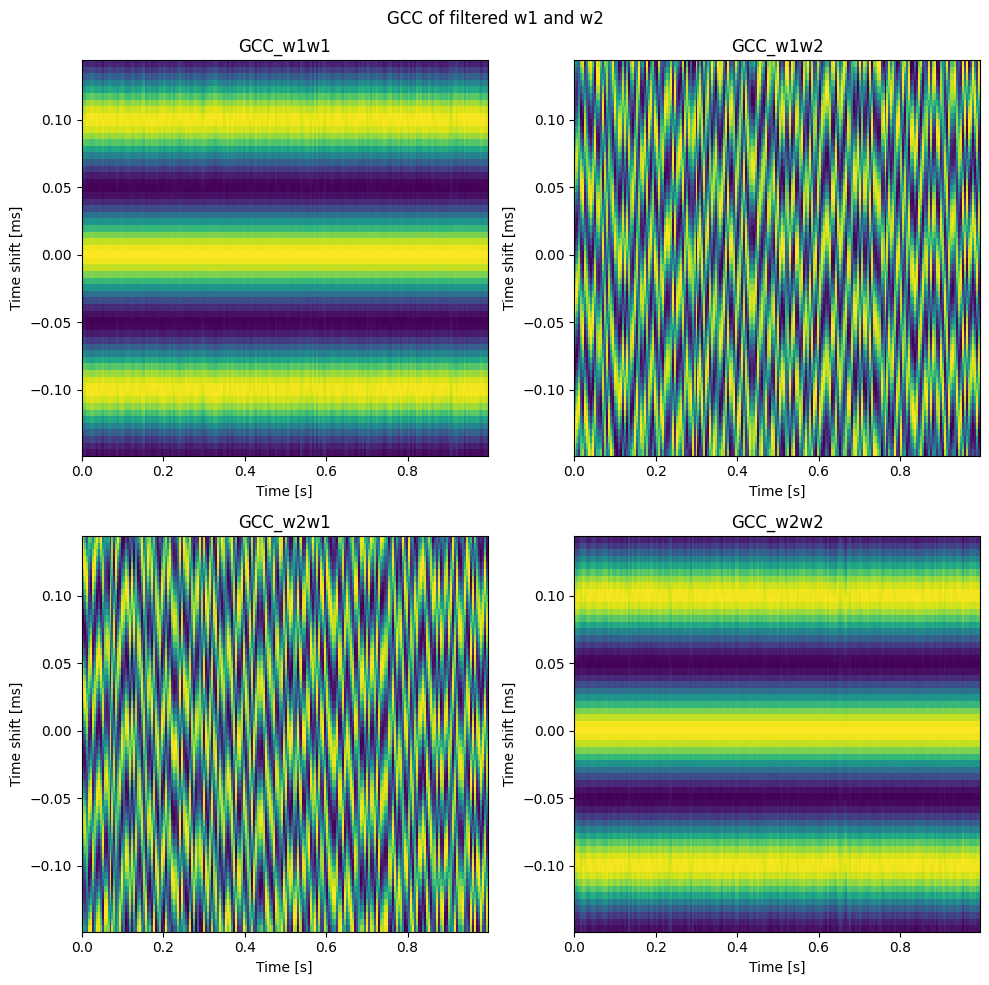

In [166]:
w1 = signal.lfilter(filter, 1.0, w1)
w2 = signal.lfilter(filter, 1.0, w2)

GCC_w1w2 = create_gcc(w1,w2, num_samples, step_size, truncate_length, window_type, beta, correlation_type)
GCC_w1w1 = create_gcc(w1,w1, num_samples, step_size, truncate_length, window_type, beta, correlation_type)
GCC_w2w2 = create_gcc(w2,w2, num_samples, step_size, truncate_length, window_type, beta, correlation_type)
GCC_w2w1 = create_gcc(w2,w1, num_samples, step_size, truncate_length, window_type, beta, correlation_type)

fig, ax = plt.subplots(2,2 ,figsize = (10,10))

ax = ax.ravel()

ax[1].pcolormesh(time, time_shifts*1000, GCC_w1w2.T, vmin = -1, vmax = 1)
ax[1].set_title('GCC_w1w2')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Time shift [ms]')
ax[1].set_aspect('auto')

ax[0].pcolormesh(time, time_shifts*1000, GCC_w1w1.T, vmin = -1, vmax = 1)
ax[0].set_title('GCC_w1w1')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Time shift [ms]')
ax[0].set_aspect('auto')


ax[3].pcolormesh(time, time_shifts*1000, GCC_w2w2.T, vmin = -1, vmax = 1)
ax[3].set_title('GCC_w2w2')
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Time shift [ms]')
ax[3].set_aspect('auto')

ax[2].pcolormesh(time, time_shifts*1000, GCC_w2w1.T, vmin = -1, vmax = 1)
ax[2].set_title('GCC_w2w1')
ax[2].set_xlabel('Time [s]')    
ax[2].set_ylabel('Time shift [ms]')
ax[2].set_aspect('auto')

fig.suptitle('GCC of filtered w1 and w2')
fig.tight_layout()